# Predicting Outcomes of Basketball Games

$\texttt{Spencer Ashton}\\$
$\texttt{Trevor Wai}\\$
$\texttt{Carson Watkin}\\$
$\texttt{Zach Joachim}\\$

### December 5, 2023

# **Introduction**

### Previous Work
Research has been done that analyzes the effect of different statistics of a given NBA game on its outcome (SOURCE). This work is helpful, as it allows players and coaches to focus on drills and metrics that will more likely lead to winning during practice and for general managers to make informed trade decisions to fill positions on rosters that correspond to the weaknesses of the team. We seek to extend this work by focusing on outcomes of games that have not been played yet.

### Projecting Future Games
While it is one thing to analyze basketball games that have already occurred to find patterns that lead to success, it is another task to assign a probability that a team wins an upcoming game. Such a result would have great implications for sports traders to set fair odds for betting, as well as for coaches to make game-specific lineup adjustments. Thus, our approach doesn't seek to predict who won a game based on the stats from that game, but it seeks to predict the outcome of a game based on previous games that both teams have played.

# **Data**

### Box Scores
We got our data by scraping basketballreference.com.  This website contains the box scores from every game sorted by team and season. A box score is a table that includes relevant statistics from each game like blocks, steals, free throws, etc. We had to combine the box scores from every team in a given season into one big dataframe representing every game played in a season.


### Data Cleaning
Talking about the cleaning from above. One challenge we ran into was that this approach included each game twice; once from each participating teams' dataset. We filtered out the duplicate games by only including the game as recorded from the home team's data. In the appendix, we show the process of cleaning the data.

### Feature Engineering
Since the box score includes points scored in a game (and that is what determines who won) a good model would pick that out and would in theory predict the winner of any game given the box score 100% of the time. Thus, we had to modify the data before feeding it into our models. We ended up reducing each box score down to four statistics for each team that used data such as field goal percentage in their calculations. These features we chose are referred to as the "Four Factors" by AUTHOR in SOURCE. These factors were shown to greatly affect the outcome of an individual game, so we created dataframes that took the four factors from each teams' games that they played so far in a given season. We later found that these converged to nearly constant values over time, so we reformulated the approach to calculate the four factors of each team from the previous $n$ games that they played. This was to align with our desire to predict games that haven't been played yet as described above. The code for the feature engineering can be found in the appendix.

### Cumulative Stats

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

2015 Accuracy:  0.5422077922077922
2016 Accuracy:  0.5844155844155844
2017 Accuracy:  0.5811688311688312
2018 Accuracy:  0.5714285714285714
2019 Accuracy:  0.5811688311688312


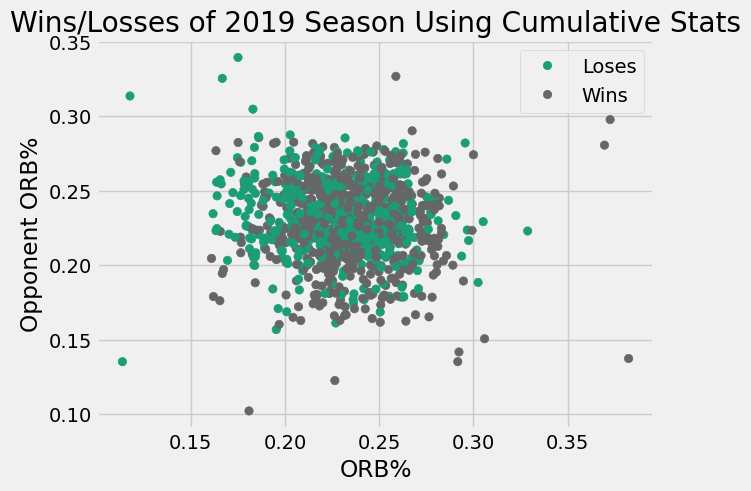

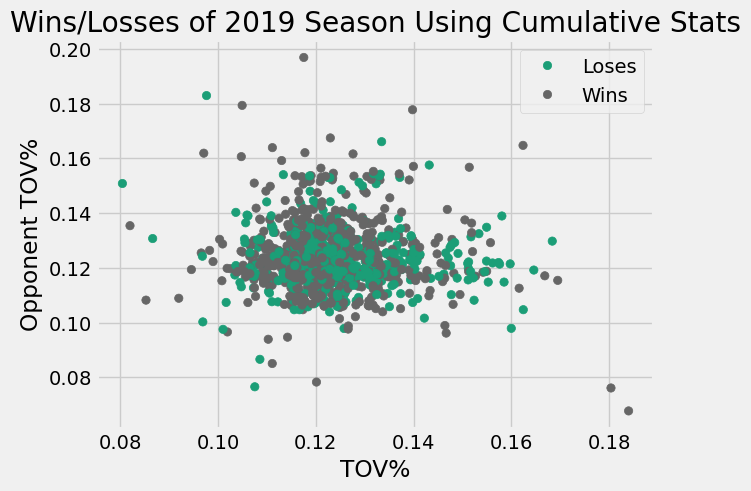

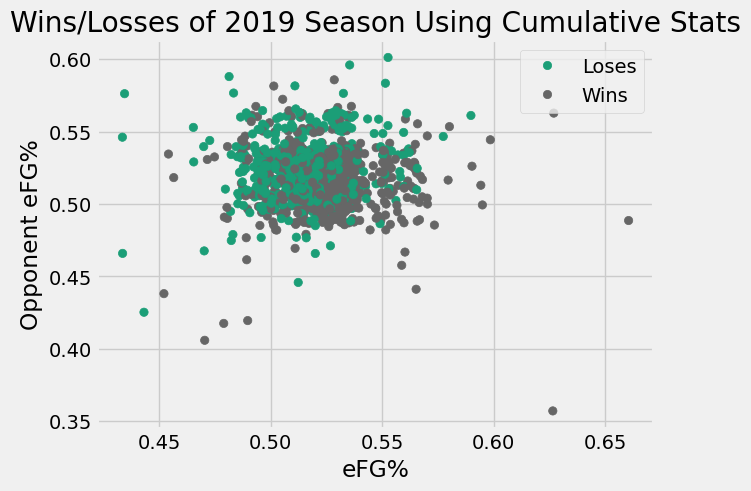

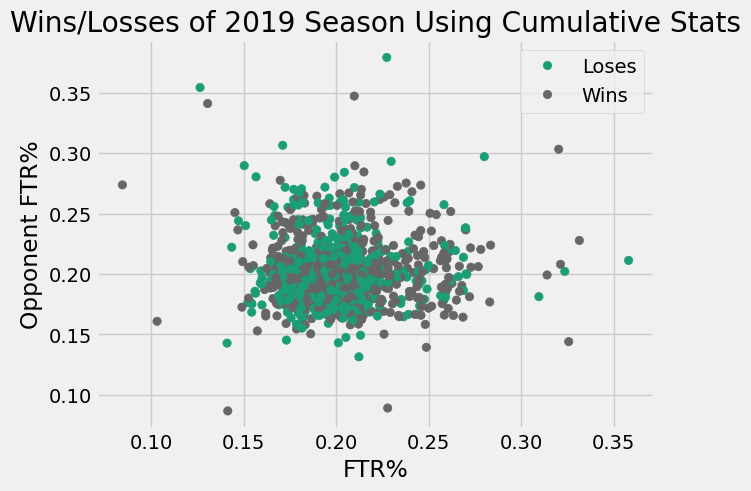

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

for year in [2015, 2016, 2017, 2018, 2019]:
    # Read the dataframe, split into training and testing sets.
    df = pd.read_csv(f"./Outputs/results_{year}.csv")
    X, X_test, y, y_test = train_test_split(df.drop(["W/L", "Date", "Team"], axis=1), df["W/L"])
    model = LogisticRegression(fit_intercept=True).fit(X, y)
    pred = model.predict(X_test)

    probabilities = model.predict_proba(X_test)[:,1]
    print(f'{year} Accuracy: ', accuracy_score(pred, y_test))

scatter = plt.scatter(df["ORB%"], df['ORB%_opp'], c=df["W/L"], cmap='Dark2')
plt.title("Wins/Losses of 2019 Season Using Cumulative Stats")
plt.xlabel("ORB%")
plt.ylabel("Opponent ORB%")
plt.legend(handles=scatter.legend_elements()[0], labels=['Loses', 'Wins'])
plt.show()

scatter = plt.scatter(df["TOV%"], df['TOV%_opp'], c=df["W/L"], cmap='Dark2')
plt.title("Wins/Losses of 2019 Season Using Cumulative Stats")
plt.xlabel("TOV%")
plt.ylabel("Opponent TOV%")
plt.legend(handles=scatter.legend_elements()[0], labels=['Loses', 'Wins'])
plt.show()

scatter = plt.scatter(df["eFG%"], df['eFG%_opp'], c=df["W/L"], cmap='Dark2')
plt.title("Wins/Losses of 2019 Season Using Cumulative Stats")
plt.xlabel("eFG%")
plt.ylabel("Opponent eFG%")
plt.legend(handles=scatter.legend_elements()[0], labels=['Loses', 'Wins'])
plt.show()

scatter = plt.scatter(df["FTR"], df['FTR_opp'], c=df["W/L"], cmap='Dark2')
plt.title("Wins/Losses of 2019 Season Using Cumulative Stats")
plt.xlabel("FTR%")
plt.ylabel("Opponent FTR%")
plt.legend(handles=scatter.legend_elements()[0], labels=['Loses', 'Wins'])
plt.show()


### Rolling Stats

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

years = [2015, 2016, 2017, 2018, 2019]
model_results = dict(zip(years, [dict(), dict(), dict(), dict(), dict()]))
tol = 0.56

for year in years:
    # Read the dataframe, split into training and testing sets.
    df = pd.read_csv(f"./Outputs/rolling_{year}.csv")
    X, X_test, y, y_test = train_test_split(df.drop(["W/L", "Date", "Team"], axis=1), df["W/L"])
    model = LogisticRegression(fit_intercept=True).fit(X, y)
    pred = model.predict(X_test)
    model_results[year]["pred"] = pred
    model_results[year]["prob"] = model.predict_proba(X_test)[:,1]
    model_results[year]["acc"] = accuracy_score(pred, y_test)
    model_results[year]["X"], model_results[year]["X_test"], model_results[year]["y"], model_results[year]["y_test"] = X, X_test, y, y_test

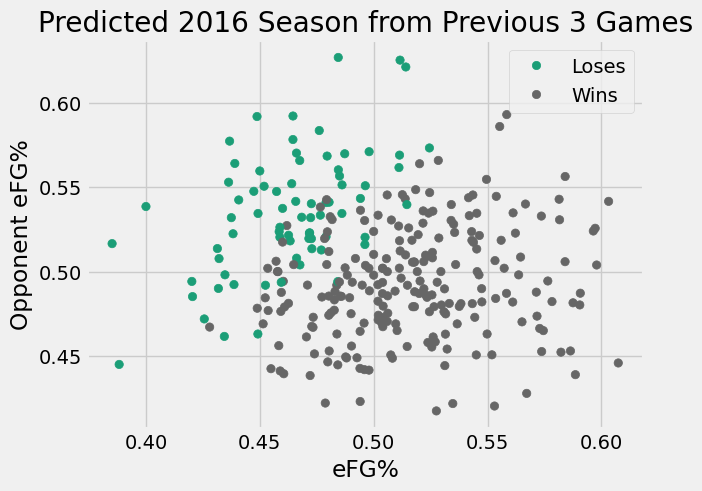

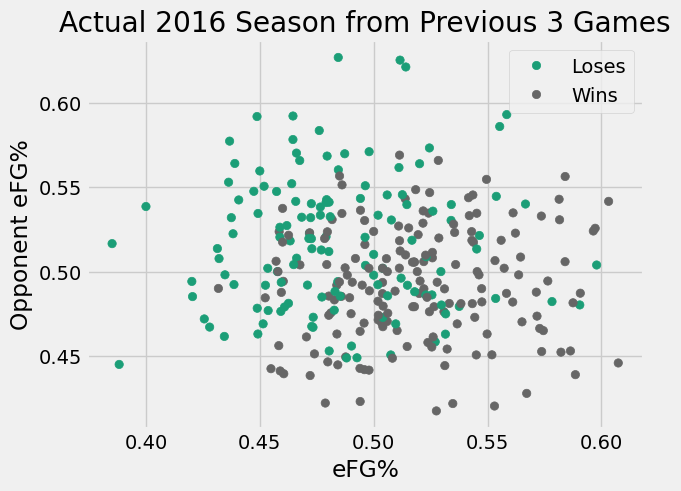

Accuracy:  0.74086


In [69]:
year = 2016
scatter = plt.scatter(model_results[year]["X_test"]["eFG%"], model_results[year]["X_test"]["eFG%_opp"], c=model_results[year]["prob"] > tol, cmap='Dark2')
plt.title(f"Predicted {year} Season from Previous 3 Games")
plt.xlabel("eFG%")
plt.ylabel("Opponent eFG%")
plt.legend(handles=scatter.legend_elements()[0], labels=['Loses', 'Wins'])
plt.show()

plt.scatter(model_results[year]["X_test"]["eFG%"], model_results[year]["X_test"]["eFG%_opp"], c=model_results[year]["y_test"], cmap='Dark2')
plt.title(f"Actual {year} Season from Previous 3 Games")
plt.xlabel("eFG%")
plt.ylabel("Opponent eFG%")
plt.legend(handles=scatter.legend_elements()[0], labels=['Loses', 'Wins'])
plt.show()

print("Accuracy: ", round((np.array(model_results[year]["prob"] > tol) == np.array(model_results[year]["y_test"])).mean(), 5))

# Results

### Cumulative vs. Rolling Stats
Running cumulative stats through our regressorrs and classifiers yielded awful results-not any better than just flipping a coin. In fact, it would only ever predict that the given team (the home team in our dataframes) would win at almost exactly the rate that the home team has won historically in the NBA. It makes sense when looking at the four factors scatter plots; there is no obvious pattern. That makes sense because teams tend to settle into a certain free throw rate throughout the course of a season, and each subsequent game is unable to affect the average by much. Thus, we decided to implement a "rolling" average. The idea behind this is we predict the outcome of a game using the four factors of the previous $n$ games, as discussed in section 2.3. This translates well to the real world where there are effects of trades throughout season, and teams take some time to find their rhythm and lineups.

### Logistic Regression
We first used logistic regresssion which output the likelihood that the home team won any game. The rolling average worked much better in this model, as we were able to achieve accuracy of around 70% when adjusting the tolerance. We found that classifying output greater than 0.59 as a win was better than the default of around 0.5.

### Random Forest Classifier
We used random forest classifiers.

In [6]:
df = pd.read_csv('./Outputs/results_2018.csv')
pX_train_c, pX_test_c, py_train_c, py_test_c = train_test_split(df.drop(["W/L", "Date", "Team"], axis=1), df["W/L"])
randomForest_classifier = RandomForestClassifier()
portfolio_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.1, 0.05, 0.01]
}
portfolio_gridsearch = GridSearchCV(randomForest_classifier, portfolio_param_grid, cv=5, scoring='accuracy')
randomForest_classifier.fit(pX_train_c, py_train_c)
py_predict_c = randomForest_classifier.predict(pX_test_c)

In [7]:
print(np.mean(py_test_c == py_predict_c))

0.672077922077922


### XGBoost
We ran an XGBoost classifier to see if it would perform better than Logistic Regression and Random Forests with its utilization of base learners. Although XGBoost takes more time in order to tune the hyperparameters, we found that XGBoost classifier performed about the same as the other classifiers, and in a few runs of the model, it performed slightly better, achieving its best accuracy at around 65%.

In [5]:
df = pd.read_csv('./Outputs/results_2018.csv')
pX_train_c, pX_test_c, py_train_c, py_test_c = train_test_split(df.drop(["W/L", "Date", "Team"], axis=1), df["W/L"])
xgboost_classifier = XGBClassifier(random_state=42)
portfolio_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.1, 0.05, 0.01]
}
portfolio_gridsearch = GridSearchCV(xgboost_classifier, portfolio_param_grid, cv=5, n_jobs=-1)
portfolio_gridsearch.fit(pX_train_c, py_train_c)
portfolio_xgboost_tuned = XGBClassifier(random_state=42, **portfolio_gridsearch.best_params_)
portfolio_xgboost_tuned.fit(pX_train_c, py_train_c)
py_predict_c = portfolio_xgboost_tuned.predict(pX_test_c)

In [ ]:
print(np.mean(py_test_c == py_predict_c))

### Model Analysis

# Ethics

 When using a model that predicts the outcome of basketball games, either ours or a better one, it is imperative to understand that no matter the accuracy of the model, it is not perfect, and will produce results that are wrong. The reason we bring this up is because of the implications in sports gambling. Gamblers look for any edge in placing bets, and if they believe the results of a model that will predict the outcome of the game, this will influence the way they place bets. However, this belief in the model is misplaced, as no model has perfect accuracy, especially ours, which can lead to people losing a lot of money. Gambling is a serious addiction, and the majority of those who gamble end up making a net negative and possibly worse in the long run, which is why people should not use this model, or any other model that predicts outcomes to games, as an influence in sports gambling.

# References

Basketball Reference. "Four Factors." Accessed October 20, 2023, https://www.basketball-reference.com/about/factors.html.



# Appendix

In [ ]:
# This cell calculates the 4 factors for the whole year
id_to_team = {'ATL': 'Atlanta Hawks', 'BOS': 'Boston Celtics', 'BRK': 'Brooklyn Nets',
        'CHO': 'Charlotte Hornets', 'CHI': 'Chicago Bulls', 'CLE': 'Cleveland Cavaliers',
        'DAL': 'Dallas Mavericks', 'DEN': 'Denver Nuggets', 'DET': 'Detroit Pistons',
        'GSW': 'Golden State Warriors', 'HOU': 'Houston Rockets', 'IND': 'Indiana Pacers',
        'LAC': 'Los Angeles Clippers', 'LAL': 'Los Angeles Lakers', 'MEM': 'Memphis Grizzlies',
        'MIA': 'Miami Heat', 'MIL': 'Milwaukee Bucks', 'MIN': 'Minnesota Timberwolves',
        'NOP': 'New Orleans Pelicans', 'NYK': 'New York Knicks', 'OKC': 'Oklahoma City Thunder',
        'ORL': 'Orlando Magic', 'PHI': 'Philadelphia 76ers', 'PHO': 'Phoenix Suns',
        'POR': 'Portland Trail Blazers', 'SAC': 'Sacramento Kings', 'SAS': 'San Antonio Spurs',
        'TOR': 'Toronto Raptors', 'UTA': 'Utah Jazz', 'WAS': 'Washington Wizards'}
team_to_id = res = dict((v,k) for k,v in id_to_team.items())
nba_path = './NBA'

for year in [2015, 2016, 2017, 2018, 2019]:
    team_dataframes = {}


    for team in os.listdir(nba_path):
        team_folder = os.path.join(nba_path, team)
        
        # Check if it's a directory
        if os.path.isdir(team_folder):
            
            # Construct the file paths
            opp_log_path = os.path.join(team_folder, f'{team_to_id[team]}_{year}_opp_game_log.csv')
            team_log_path = os.path.join(team_folder, f'{team_to_id[team]}_{year}_team_game_log.csv')
            
            # Read the CSV files into dataframes
            opp_log_df = pd.read_csv(opp_log_path, index_col=1)
            team_log_df = pd.read_csv(team_log_path, index_col=1)

            # Clean and engineer the opponent data:
            opp_log_df.drop('Unnamed: 0', axis=1, inplace=True)
            opp_log_df.fillna(value={'H/A': 'vs'}, inplace=True)
            opp_log_df.dropna(inplace=True)
            opp_log_df.rename(columns={'Tm': 'Team Score', 'Opp.1': 'Opp Score'}, inplace=True)
            opp_log_df["FG_cum"] = opp_log_df["FG"].cumsum()
            opp_log_df["3P_cum"] = opp_log_df["3P"].cumsum()
            opp_log_df["FGA_cum"] = opp_log_df["FGA"].cumsum()
            opp_log_df['TOV_cum'] = opp_log_df['TOV'].cumsum()
            opp_log_df['FTA_cum'] = opp_log_df['FTA'].cumsum()
            opp_log_df['ORB_cum'] = opp_log_df['ORB'].cumsum()
            opp_log_df['TRB_cum'] = opp_log_df['TRB'].cumsum()
            opp_log_df['FT_cum'] = opp_log_df['FT'].cumsum()

            # Clean and engineer the team data:
            team_log_df.drop('Unnamed: 0', axis=1, inplace=True)
            team_log_df.fillna(value={'H/A': 'vs'}, inplace=True)
            team_log_df.dropna(inplace=True)
            team_log_df.rename(columns={'Tm': 'Team Score', 'Opp.1': 'Opp Score'}, inplace=True)
            team_log_df["FG_cum"] = team_log_df["FG"].cumsum()
            team_log_df["3P_cum"] = team_log_df["3P"].cumsum()
            team_log_df["FGA_cum"] = team_log_df["FGA"].cumsum()
            team_log_df['TOV_cum'] = team_log_df['TOV'].cumsum()
            team_log_df['FTA_cum'] = team_log_df['FTA'].cumsum()
            team_log_df['ORB_cum'] = team_log_df['ORB'].cumsum()
            team_log_df['TRB_cum'] = team_log_df['TRB'].cumsum()
            team_log_df['FT_cum'] = team_log_df['FT'].cumsum()

            
            # Create four_factors on opponent data.
            opp_four_factors = pd.DataFrame({'Team':[],
                                    'Date':[],
                                    'eFG%':[],
                                    'TOV%':[],
                                    'ORB%':[],
                                    'FTR':[],})

            opp_four_factors['Team'] = opp_log_df['Opp']
            opp_four_factors['Date'] = opp_log_df['Date']
            opp_four_factors.set_index('Date', inplace=True)

            # Create four factors on team data.
            team_four_factors = pd.DataFrame({'Date':[],
                                    'W/L': [],
                                    'H/A':[],
                                    'eFG%':[],
                                    'TOV%':[],
                                    'ORB%':[],
                                    'FTR':[]})

            team_four_factors['Date'] = team_log_df['Date']
            team_four_factors['W/L'] = team_log_df['W/L'].replace({'W': 1, 'L': 0})
            team_four_factors['H/A'] = team_log_df['H/A']
            team_four_factors["eFG%"] = (team_log_df['FG_cum'] + 0.5 * team_log_df['3P_cum']) / team_log_df['FGA_cum']
            team_four_factors['TOV%'] = team_log_df['TOV_cum'] / (team_log_df['FGA_cum'] + 0.44 * team_log_df['FTA_cum'] + team_log_df['TOV_cum'])
            team_four_factors['ORB%'] = team_log_df['ORB_cum'] / (team_log_df['ORB_cum'] + (opp_log_df['TRB_cum'] - opp_log_df['ORB_cum']))
            team_four_factors['FTR'] = team_log_df['FT_cum'] / team_log_df['FGA_cum']
            team_four_factors.set_index('Date', inplace=True)
            team_four_factors.loc[team_four_factors['H/A'] == '@', 'H/A'] = 0
            team_four_factors.loc[team_four_factors['H/A'] == 'vs', 'H/A'] = 1

            result = team_four_factors.join(opp_four_factors, rsuffix='_opp', on='Date')
            
            # Store the dataframes in the dictionary
            team_dataframes[team_to_id[team]] = {'opp_log': opp_log_df, 'team_log': team_log_df, 'result': result}

    # Store the opponent 4 factors.
    for team in team_dataframes:
        orb_opp = []
        ftr_opp = []
        tov_opp = []
        efg_opp = []
        for i in range(82):
            date = team_dataframes[team]["result"].index[i]
            orb_opp.append(team_dataframes[team_dataframes[team]["result"]["Team"].values[i]]["result"].at[date, "ORB%"])
            ftr_opp.append(team_dataframes[team_dataframes[team]["result"]["Team"].values[i]]["result"].at[date, "FTR"])
            tov_opp.append(team_dataframes[team_dataframes[team]["result"]["Team"].values[i]]["result"].at[date, "TOV%"])
            efg_opp.append(team_dataframes[team_dataframes[team]["result"]["Team"].values[i]]["result"].at[date, "eFG%"])
        team_dataframes[team]["result"]["ORB%_opp"] = orb_opp
        team_dataframes[team]["result"]["FTR_opp"] = ftr_opp
        team_dataframes[team]["result"]["TOV%_opp"] = tov_opp
        team_dataframes[team]["result"]["eFG%_opp"] = efg_opp

    for team in team_dataframes.keys():
        team_dataframes[team]["result"] = team_dataframes[team]["result"][team_dataframes[team]["result"]['H/A'] != 0] # Only include home games.

    df_list = []
    for team in team_dataframes.keys():
        df_list.append(team_dataframes[team]["result"])
    concatenated_df = pd.concat(df_list, ignore_index=False)
    concatenated_df.values.shape

    file_path = f'./Outputs/results_{year}.csv'

    # Export the DataFrame to a CSV file
    concatenated_df.to_csv(file_path, index=True)

In [ ]:
# This cell creates rolling stats from the previous n games.
id_to_team = {'ATL': 'Atlanta Hawks', 'BOS': 'Boston Celtics', 'BRK': 'Brooklyn Nets',
        'CHO': 'Charlotte Hornets', 'CHI': 'Chicago Bulls', 'CLE': 'Cleveland Cavaliers',
        'DAL': 'Dallas Mavericks', 'DEN': 'Denver Nuggets', 'DET': 'Detroit Pistons',
        'GSW': 'Golden State Warriors', 'HOU': 'Houston Rockets', 'IND': 'Indiana Pacers',
        'LAC': 'Los Angeles Clippers', 'LAL': 'Los Angeles Lakers', 'MEM': 'Memphis Grizzlies',
        'MIA': 'Miami Heat', 'MIL': 'Milwaukee Bucks', 'MIN': 'Minnesota Timberwolves',
        'NOP': 'New Orleans Pelicans', 'NYK': 'New York Knicks', 'OKC': 'Oklahoma City Thunder',
        'ORL': 'Orlando Magic', 'PHI': 'Philadelphia 76ers', 'PHO': 'Phoenix Suns',
        'POR': 'Portland Trail Blazers', 'SAC': 'Sacramento Kings', 'SAS': 'San Antonio Spurs',
        'TOR': 'Toronto Raptors', 'UTA': 'Utah Jazz', 'WAS': 'Washington Wizards'}
team_to_id = res = dict((v,k) for k,v in id_to_team.items())
nba_path = './NBA'
n = 3

for year in [2015, 2016, 2017, 2018, 2019]:
    team_dataframes = {}

    for team in os.listdir(nba_path):
        team_folder = os.path.join(nba_path, team)
        
        # Check if it's a directory
        if os.path.isdir(team_folder):
            
            # Construct the file paths
            opp_log_path = os.path.join(team_folder, f'{team_to_id[team]}_{year}_opp_game_log.csv')
            team_log_path = os.path.join(team_folder, f'{team_to_id[team]}_{year}_team_game_log.csv')
            
            # Read the CSV files into dataframes
            opp_log_df = pd.read_csv(opp_log_path, index_col=1)
            team_log_df = pd.read_csv(team_log_path, index_col=1)

            # Clean and engineer the opponent data:
            opp_log_df.drop('Unnamed: 0', axis=1, inplace=True)
            opp_log_df.fillna(value={'H/A': 'vs'}, inplace=True)
            opp_log_df.dropna(inplace=True)
            opp_log_df.rename(columns={'Tm': 'Team Score', 'Opp.1': 'Opp Score'}, inplace=True)
            opp_log_df["FG_cum"] = opp_log_df["FG"].rolling(n).sum()
            opp_log_df["3P_cum"] = opp_log_df["3P"].rolling(n).sum()
            opp_log_df["FGA_cum"] = opp_log_df["FGA"].rolling(n).sum()
            opp_log_df['TOV_cum'] = opp_log_df['TOV'].rolling(n).sum()
            opp_log_df['FTA_cum'] = opp_log_df['FTA'].rolling(n).sum()
            opp_log_df['ORB_cum'] = opp_log_df['ORB'].rolling(n).sum()
            opp_log_df['TRB_cum'] = opp_log_df['TRB'].rolling(n).sum()
            opp_log_df['FT_cum'] = opp_log_df['FT'].rolling(n).sum()
            opp_log_df.dropna(inplace=True)

            # Clean and engineer the team data:
            team_log_df.drop('Unnamed: 0', axis=1, inplace=True)
            team_log_df.fillna(value={'H/A': 'vs'}, inplace=True)
            team_log_df.dropna(inplace=True)
            team_log_df.rename(columns={'Tm': 'Team Score', 'Opp.1': 'Opp Score'}, inplace=True)
            team_log_df["FG_cum"] = team_log_df["FG"].rolling(n).sum()
            team_log_df["3P_cum"] = team_log_df["3P"].rolling(n).sum()
            team_log_df["FGA_cum"] = team_log_df["FGA"].rolling(n).sum()
            team_log_df['TOV_cum'] = team_log_df['TOV'].rolling(n).sum()
            team_log_df['FTA_cum'] = team_log_df['FTA'].rolling(n).sum()
            team_log_df['ORB_cum'] = team_log_df['ORB'].rolling(n).sum()
            team_log_df['TRB_cum'] = team_log_df['TRB'].rolling(n).sum()
            team_log_df['FT_cum'] = team_log_df['FT'].rolling(n).sum()
            team_log_df.dropna(inplace=True)

            
            # Create four_factors on opponent data.
            opp_four_factors = pd.DataFrame({'Team':[],
                                    'Date':[],
                                    'eFG%':[],
                                    'TOV%':[],
                                    'ORB%':[],
                                    'FTR':[],})

            opp_four_factors['Team'] = opp_log_df['Opp']
            opp_four_factors['Date'] = opp_log_df['Date']
            opp_four_factors.set_index('Date', inplace=True)

            # Create four factors on team data.
            team_four_factors = pd.DataFrame({'Date':[],
                                    'W/L': [],
                                    'H/A':[],
                                    'eFG%':[],
                                    'TOV%':[],
                                    'ORB%':[],
                                    'FTR':[]})

            team_four_factors['Date'] = team_log_df['Date']
            team_four_factors['W/L'] = team_log_df['W/L'].replace({'W': 1, 'L': 0})
            team_four_factors['H/A'] = team_log_df['H/A']
            team_four_factors["eFG%"] = (team_log_df['FG_cum'] + 0.5 * team_log_df['3P_cum']) / team_log_df['FGA_cum']
            team_four_factors['TOV%'] = team_log_df['TOV_cum'] / (team_log_df['FGA_cum'] + 0.44 * team_log_df['FTA_cum'] + team_log_df['TOV_cum'])
            team_four_factors['ORB%'] = team_log_df['ORB_cum'] / (team_log_df['ORB_cum'] + (opp_log_df['TRB_cum'] - opp_log_df['ORB_cum']))
            team_four_factors['FTR'] = team_log_df['FT_cum'] / team_log_df['FGA_cum']
            team_four_factors.set_index('Date', inplace=True)
            team_four_factors.loc[team_four_factors['H/A'] == '@', 'H/A'] = 0
            team_four_factors.loc[team_four_factors['H/A'] == 'vs', 'H/A'] = 1

            result = team_four_factors.join(opp_four_factors, rsuffix='_opp', on='Date')
            
            # Store the dataframes in the dictionary
            team_dataframes[team_to_id[team]] = {'opp_log': opp_log_df, 'team_log': team_log_df, 'result': result}

    # Store the opponent 4 factors.
    for team in team_dataframes:
        orb_opp = []
        ftr_opp = []
        tov_opp = []
        efg_opp = []
        for i in range(82-n+1):
            date = team_dataframes[team]["result"].index[i]
            opp_data = team_dataframes[team_dataframes[team]["result"]["Team"].values[i]]["result"]
            # Look up the opponent's stats at that date, unless that already (beginning of season NaNs dropped)
            orb_opp.append(opp_data.at[date, "ORB%"] if date in opp_data.index else opp_data["ORB%"].values[0])
            ftr_opp.append(opp_data.at[date, "FTR"] if date in opp_data.index else opp_data["FTR"].values[0])
            tov_opp.append(opp_data.at[date, "TOV%"] if date in opp_data.index else opp_data["TOV%"].values[0])
            efg_opp.append(opp_data.at[date, "eFG%"] if date in opp_data.index else opp_data["eFG%"].values[0])

        team_dataframes[team]["result"]["ORB%_opp"] = orb_opp
        team_dataframes[team]["result"]["FTR_opp"] = ftr_opp
        team_dataframes[team]["result"]["TOV%_opp"] = tov_opp
        team_dataframes[team]["result"]["eFG%_opp"] = efg_opp

    for team in team_dataframes.keys():
        team_dataframes[team]["result"] = team_dataframes[team]["result"][team_dataframes[team]["result"]['H/A'] != 0] # Only include home games.

    df_list = []
    for team in team_dataframes.keys():
        df_list.append(team_dataframes[team]["result"])
    concatenated_df = pd.concat(df_list, ignore_index=False)
    concatenated_df.values.shape

    file_path = f'./Outputs/rolling_{year}.csv'

    # Export the DataFrame to a CSV file
    concatenated_df.to_csv(file_path, index=True)